In [2]:
# --------- IMPORTS ----------
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D, Flatten,
    Conv2D, BatchNormalization, Activation, MaxPooling2D,
    SeparableConv2D
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
# --------- CONFIG ----------
picture_size = 48
folder_path = r"C:/Users/hbish/Downloads/Real-time stress detector/images"

batch_size  = 64         # smaller batch helps learning
epochs      = 60         # EarlyStopping will stop earlier if needed


In [4]:
# --------- DATA GENERATORS ----------
datagen_train = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

datagen_val = ImageDataGenerator(
    rescale=1.0/255
)

train_set = datagen_train.flow_from_directory(
    folder_path + "/train",
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_set = datagen_val.flow_from_directory(
    folder_path + "/validation",
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print("Class indices:", train_set.class_indices)
num_classes = len(train_set.class_indices)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [5]:
# --------- MINI-XCEPTION STYLE MODEL ----------
model = Sequential()

# Entry block
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(picture_size, picture_size, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Block 2
model.add(SeparableConv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(SeparableConv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Block 3
model.add(SeparableConv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(SeparableConv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Block 4
model.add(SeparableConv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(SeparableConv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

# Global pooling instead of huge Dense layers
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

opt = Adam(learning_rate=1e-3)   # higher LR than before

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


C:\Users\hbish\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 24, 24, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 24, 24, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 12, 12, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 12, 12, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 151,175 (590.53 KB)

 Trainable params: 149,255 (583.03 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [6]:
# --------- CALLBACKS ----------
checkpoint = ModelCheckpoint(
    "./model.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    verbose=1,
    min_lr=1e-6
)

callbacks_list = [checkpoint, early_stopping, reduce_lr]

In [7]:
# --------- TRAIN ----------
history = model.fit(
    train_set,
    epochs=epochs,
    validation_data=val_set,
    callbacks=callbacks_list
)

Epoch 1/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.2023 - loss: 2.1395
Epoch 1: val_accuracy improved from None to 0.25828, saving model to ./model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 67s 140ms/step - accuracy: 0.2157 - loss: 1.9612 - val_accuracy: 0.2583 - val_loss: 1.8231 - learning_rate: 0.0010
Epoch 2/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.2416 - loss: 1.8046
Epoch 2: val_accuracy improved from 0.25828 to 0.25955, saving model to ./model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - accuracy: 0.2462 - loss: 1.7985 - val_accuracy: 0.2596 - val_loss: 1.7542 - learning_rate: 0.0010
Epoch 3/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.2686 - loss: 1.7676
Epoch 3: val_accuracy improved from 0.25955 to 0.26111, saving model to ./model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - accuracy: 0.2689 - loss: 1.7646 - val_accuracy: 0.2611 - val_loss: 1.8736 - learning_rate: 0.0010
Epoch 4/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.2962 - loss: 1.7240
Epoch 4: val_accuracy improved from 0.26111 to 0.26691, saving model to ./model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - accuracy: 0.3051 - loss: 1.7077 - val_accuracy: 0.2669 - val_loss: 1.7530 - learning_rate: 0.0010
Epoch 5/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3511 - loss: 1.6322
Epoch 5: val_accuracy improved from 0.26691 to 0.41282, saving model to ./model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - accuracy: 0.3658 - loss: 1.6051 - val_accuracy: 0.4128 - val_loss: 1.4966 - learning_rate: 0.0010
Epoch 6/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4050 - loss: 1.5355
Epoch 6: val_accuracy did not improve from 0.41282
451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - accuracy: 0.4087 - loss: 1.5239 - val_accuracy: 0.3688 - val_loss: 1.7941 - learning_rate: 0.0010
Epoch 7/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4287 - loss: 1.4830
Epoch 7: val_accuracy improved from 0.41282 to 0.48571, saving model to ./model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - accuracy: 0.4334 - loss: 1.4736 - val_accuracy: 0.4857 - val_loss: 1.3843 - learning_rate: 0.0010
Epoch 8/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4510 - loss: 1.4307
Epoch 8: val_accuracy improved from 0.48571 to 0.53779, saving model to ./model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 54s 120ms/step - accuracy: 0.4550 - loss: 1.4219 - val_accuracy: 0.5378 - val_loss: 1.2218 - learning_rate: 0.0010
Epoch 9/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4661 - loss: 1.4018
Epoch 9: val_accuracy did not improve from 0.53779
451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - accuracy: 0.4707 - loss: 1.3875 - val_accuracy: 0.5031 - val_loss: 1.2953 - learning_rate: 0.0010
Epoch 10/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4793 - loss: 1.3689
Epoch 10: val_accuracy did not improve from 0.53779
451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - accuracy: 0.4800 - loss: 1.3632 - val_accuracy: 0.5297 - val_loss: 1.2514 - learning_rate: 0.0010
Epoch 11/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4863 - loss: 1.3423
Epoch 11: val_accuracy did not improve from 0.53779
451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - accuracy: 0.4893 - loss: 1.3398 - val_accuracy: 0.5170 - val_loss: 1.2562 - learning_rate: 0.0010
Epo

451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - accuracy: 0.4936 - loss: 1.3313 - val_accuracy: 0.5511 - val_loss: 1.1967 - learning_rate: 0.0010
Epoch 13/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4946 - loss: 1.3179
Epoch 13: val_accuracy improved from 0.55109 to 0.55265, saving model to ./model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - accuracy: 0.4997 - loss: 1.3118 - val_accuracy: 0.5526 - val_loss: 1.1885 - learning_rate: 0.0010
Epoch 14/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5075 - loss: 1.3014
Epoch 14: val_accuracy did not improve from 0.55265
451/451 ━━━━━━━━━━━━━━━━━━━━ 55s 123ms/step - accuracy: 0.5057 - loss: 1.3023 - val_accuracy: 0.5250 - val_loss: 1.2490 - learning_rate: 0.0010
Epoch 15/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5095 - loss: 1.2832
Epoch 15: val_accuracy did not improve from 0.55265
451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - accuracy: 0.5100 - loss: 1.2867 - val_accuracy: 0.4953 - val_loss: 1.4007 - learning_rate: 0.0010
Epoch 16/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5087 - loss: 1.2932
Epoch 16: val_accuracy improved from 0.55265 to 0.57430, saving model to ./model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5143 - loss: 1.2804 - val_accuracy: 0.5743 - val_loss: 1.1259 - learning_rate: 0.0010
Epoch 17/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5108 - loss: 1.2802
Epoch 17: val_accuracy did not improve from 0.57430
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5191 - loss: 1.2648 - val_accuracy: 0.5463 - val_loss: 1.2018 - learning_rate: 0.0010
Epoch 18/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5224 - loss: 1.2595
Epoch 18: val_accuracy did not improve from 0.57430
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5231 - loss: 1.2604 - val_accuracy: 0.5594 - val_loss: 1.1558 - learning_rate: 0.0010
Epoch 19/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5231 - loss: 1.2466
Epoch 19: val_accuracy did not improve from 0.57430
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5238 - loss: 1.2473 - val_accuracy: 0.5450 - val_loss: 1.1979 - learning_rate: 0.0010
E

451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5400 - loss: 1.2110 - val_accuracy: 0.5777 - val_loss: 1.1023 - learning_rate: 5.0000e-04
Epoch 22/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5446 - loss: 1.1984
Epoch 22: val_accuracy did not improve from 0.57770
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - accuracy: 0.5488 - loss: 1.1976 - val_accuracy: 0.5732 - val_loss: 1.1462 - learning_rate: 5.0000e-04
Epoch 23/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5479 - loss: 1.1948
Epoch 23: val_accuracy improved from 0.57770 to 0.58973, saving model to ./model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5463 - loss: 1.1924 - val_accuracy: 0.5897 - val_loss: 1.0781 - learning_rate: 5.0000e-04
Epoch 24/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5502 - loss: 1.1896
Epoch 24: val_accuracy improved from 0.58973 to 0.59425, saving model to ./model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5508 - loss: 1.1873 - val_accuracy: 0.5943 - val_loss: 1.0622 - learning_rate: 5.0000e-04
Epoch 25/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5560 - loss: 1.1837
Epoch 25: val_accuracy did not improve from 0.59425
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - accuracy: 0.5529 - loss: 1.1821 - val_accuracy: 0.5828 - val_loss: 1.1189 - learning_rate: 5.0000e-04
Epoch 26/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5506 - loss: 1.1861
Epoch 26: val_accuracy improved from 0.59425 to 0.60204, saving model to ./model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5522 - loss: 1.1778 - val_accuracy: 0.6020 - val_loss: 1.0445 - learning_rate: 5.0000e-04
Epoch 27/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5581 - loss: 1.1751
Epoch 27: val_accuracy improved from 0.60204 to 0.60331, saving model to ./model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 116ms/step - accuracy: 0.5573 - loss: 1.1754 - val_accuracy: 0.6033 - val_loss: 1.0443 - learning_rate: 5.0000e-04
Epoch 28/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5533 - loss: 1.1742
Epoch 28: val_accuracy did not improve from 0.60331
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - accuracy: 0.5573 - loss: 1.1698 - val_accuracy: 0.5783 - val_loss: 1.1112 - learning_rate: 5.0000e-04
Epoch 29/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5620 - loss: 1.1650
Epoch 29: val_accuracy did not improve from 0.60331
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - accuracy: 0.5631 - loss: 1.1658 - val_accuracy: 0.5841 - val_loss: 1.0706 - learning_rate: 5.0000e-04
Epoch 30/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5588 - loss: 1.1585
Epoch 30: val_accuracy did not improve from 0.60331
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - accuracy: 0.5557 - loss: 1.1648 - val_accuracy: 0.5938 - val_loss: 1.0584 - learning_ra

451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - accuracy: 0.5657 - loss: 1.1473 - val_accuracy: 0.6091 - val_loss: 1.0281 - learning_rate: 2.5000e-04
Epoch 33/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5666 - loss: 1.1397
Epoch 33: val_accuracy improved from 0.60911 to 0.61180, saving model to ./model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - accuracy: 0.5681 - loss: 1.1416 - val_accuracy: 0.6118 - val_loss: 1.0236 - learning_rate: 2.5000e-04
Epoch 34/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5710 - loss: 1.1351
Epoch 34: val_accuracy did not improve from 0.61180
451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 116ms/step - accuracy: 0.5713 - loss: 1.1360 - val_accuracy: 0.6015 - val_loss: 1.0564 - learning_rate: 2.5000e-04
Epoch 35/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5704 - loss: 1.1397
Epoch 35: val_accuracy did not improve from 0.61180
451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - accuracy: 0.5704 - loss: 1.1367 - val_accuracy: 0.6053 - val_loss: 1.0570 - learning_rate: 2.5000e-04
Epoch 36/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5741 - loss: 1.1282
Epoch 36: val_accuracy did not improve from 0.61180
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5697 - loss: 1.1386 - val_accuracy: 0.6063 - val_loss: 1.0289 - learning_ra

451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - accuracy: 0.5746 - loss: 1.1295 - val_accuracy: 0.6135 - val_loss: 1.0168 - learning_rate: 2.5000e-04
Epoch 38/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5700 - loss: 1.1246
Epoch 38: val_accuracy did not improve from 0.61350
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5678 - loss: 1.1301 - val_accuracy: 0.6064 - val_loss: 1.0226 - learning_rate: 2.5000e-04
Epoch 39/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5769 - loss: 1.1203
Epoch 39: val_accuracy improved from 0.61350 to 0.61492, saving model to ./model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5728 - loss: 1.1301 - val_accuracy: 0.6149 - val_loss: 1.0171 - learning_rate: 2.5000e-04
Epoch 40/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5722 - loss: 1.1280
Epoch 40: val_accuracy did not improve from 0.61492
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5744 - loss: 1.1262 - val_accuracy: 0.6059 - val_loss: 1.0460 - learning_rate: 2.5000e-04
Epoch 41/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5799 - loss: 1.1203
Epoch 41: val_accuracy improved from 0.61492 to 0.62228, saving model to ./model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5740 - loss: 1.1249 - val_accuracy: 0.6223 - val_loss: 1.0021 - learning_rate: 2.5000e-04
Epoch 42/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5784 - loss: 1.1235
Epoch 42: val_accuracy did not improve from 0.62228
451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - accuracy: 0.5752 - loss: 1.1253 - val_accuracy: 0.6063 - val_loss: 1.0377 - learning_rate: 2.5000e-04
Epoch 43/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5750 - loss: 1.1218
Epoch 43: val_accuracy improved from 0.62228 to 0.62454, saving model to ./model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5762 - loss: 1.1180 - val_accuracy: 0.6245 - val_loss: 0.9972 - learning_rate: 2.5000e-04
Epoch 44/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5767 - loss: 1.1309
Epoch 44: val_accuracy did not improve from 0.62454
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5767 - loss: 1.1225 - val_accuracy: 0.6056 - val_loss: 1.0341 - learning_rate: 2.5000e-04
Epoch 45/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5748 - loss: 1.1234
Epoch 45: val_accuracy did not improve from 0.62454
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5770 - loss: 1.1185 - val_accuracy: 0.6080 - val_loss: 1.0356 - learning_rate: 2.5000e-04
Epoch 46/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5766 - loss: 1.1172
Epoch 46: val_accuracy did not improve from 0.62454
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5766 - loss: 1.1175 - val_accuracy: 0.6220 - val_loss: 1.0089 - learning_ra

451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - accuracy: 0.5783 - loss: 1.1084 - val_accuracy: 0.6257 - val_loss: 0.9959 - learning_rate: 1.2500e-04
Epoch 49/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5769 - loss: 1.1189
Epoch 49: val_accuracy did not improve from 0.62567
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5809 - loss: 1.1055 - val_accuracy: 0.6152 - val_loss: 1.0138 - learning_rate: 1.2500e-04
Epoch 50/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5788 - loss: 1.1115
Epoch 50: val_accuracy did not improve from 0.62567
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - accuracy: 0.5794 - loss: 1.1057 - val_accuracy: 0.6241 - val_loss: 0.9983 - learning_rate: 1.2500e-04
Epoch 51/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5783 - loss: 1.1024
Epoch 51: val_accuracy did not improve from 0.62567
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5801 - loss: 1.1075 - val_accuracy: 0.6221 - val_loss: 1.0009 - learning_ra

451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5829 - loss: 1.1012 - val_accuracy: 0.6258 - val_loss: 0.9940 - learning_rate: 1.2500e-04
Epoch 53/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5795 - loss: 1.1054
Epoch 53: val_accuracy did not improve from 0.62581
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - accuracy: 0.5825 - loss: 1.1047 - val_accuracy: 0.6203 - val_loss: 1.0027 - learning_rate: 1.2500e-04
Epoch 54/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5846 - loss: 1.0974
Epoch 54: val_accuracy did not improve from 0.62581
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - accuracy: 0.5840 - loss: 1.0991 - val_accuracy: 0.6258 - val_loss: 0.9921 - learning_rate: 1.2500e-04
Epoch 55/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5787 - loss: 1.1089
Epoch 55: val_accuracy improved from 0.62581 to 0.62666, saving model to ./model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - accuracy: 0.5827 - loss: 1.1005 - val_accuracy: 0.6267 - val_loss: 0.9915 - learning_rate: 1.2500e-04
Epoch 56/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5923 - loss: 1.0939
Epoch 56: val_accuracy did not improve from 0.62666
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5829 - loss: 1.1036 - val_accuracy: 0.6214 - val_loss: 1.0079 - learning_rate: 1.2500e-04
Epoch 57/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5825 - loss: 1.0957
Epoch 57: val_accuracy did not improve from 0.62666
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - accuracy: 0.5812 - loss: 1.1023 - val_accuracy: 0.6186 - val_loss: 1.0014 - learning_rate: 1.2500e-04
Epoch 58/60
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5925 - loss: 1.0904
Epoch 58: val_accuracy did not improve from 0.62666
451/451 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5888 - loss: 1.0933 - val_accuracy: 0.6231 - val_loss: 0.9944 - learning_ra

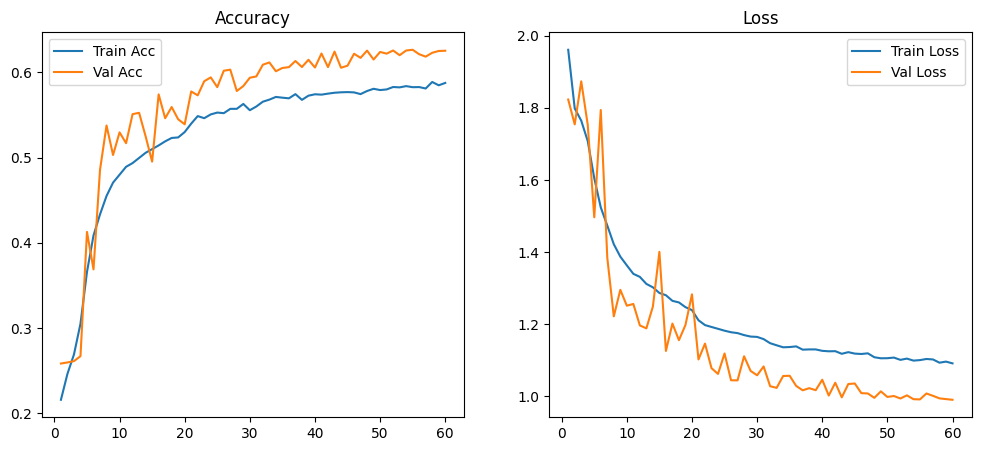

Training done. Best model saved as model.h5


In [8]:
# --------- PLOT ----------
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc)+1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

print("Training done. Best model saved as model.h5")

In [9]:
import sys
print(sys.executable)

C:\Users\hbish\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe
